<a href="https://colab.research.google.com/github/adhadse/colab_repo/blob/master/homl/Ch%2017%20Representation%20Learning%20and%20Generative%20Learning%20Using%20Autoencoders%20and%20GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 17: Representation Learning and Generative Learning Using Autoencoders and GANs
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is only supposed to be used as reference and is recommended to follow along with a copy of the Book purchased.

This chapter will introduce <mark>***Autoencoders***, which are artificial neural networks capable of learning dense represenataions of the input data, called *latent representations* or *codings*, without any supervision.</mark>

They are usefull for:
- Dimensionality reduction
- Feature detection
- for unsupervised pretraining of deep neural networks
- can be *genrative models* as well.

The other things this chapter will focus on is <mark> ***Genrative Adversarial Networks*** (GANs), which are composed of two neural networks: a *generator* that tries to generate data that looks similar to the training data, and a *discriminator* that tries to tell the real data from fake data.</mark> And so they bought compete each other trying to become better. This is *Adversarial training* (training competing neural networks).

We'll begin by 
- How encoders work
- How to use them for dimensionality reduction.
- feature extraction,
- unsupervised pretraining
- or a genrative models.

Which will lead us to GANs.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Efficient Data Representations
<mark>An autoencoder looks at the inputs, converts them to an efficient latent representation, and then gives out something that (hopefully) looks very close to the inputs. 
</mark>
It's always composed of two parts:
- *Encoder* (or *recognition network*): converts the inputs to a latent representation. Followed by,
- *Decoder* (or *generative network*): converts the internal representations to the outputs.

An autoencoder is said to be *undercomplete*. <mark>An undercomplete autoencoder cannot trivially  copy its inputs to the codings, so it must find the most important features and learn to output a copy of its inputs.</mark>

They ususally have same architecture as MLP, except that the number of neurons in the output layer must be equal to the number of inputs.


# Performing PCA with an Undercomplete Linear Autoencoder
<mark> If the autoencoder uses only linear activations and the cost function is the Mean squared error (MSE), then it ends up performing Principle Component Analysis.</mark>

Let's build an autoencoder to perfrom PCA. First off we'll Build 3D dataset.

In [ ]:
np.random.seed(4)
tf.random.set_seed(42)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [ ]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])]) # decoder's output is equal to 
autoencoder = keras.models.Sequential([encoder, decoder])                   # no. of inputs to encoder inputs, here 3.

autoencoder.compile(loss="mse", 
                    optimizer=keras.optimizers.SGD(learning_rate=0.1))

autoencoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 2)                 8         
_________________________________________________________________
sequential_9 (Sequential)    (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=20)  # the same dataset X_train is used
                                                        # for both the inputs and the targets

Epoch 1/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3019
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.2836
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2667
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2520
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 4ms/step - loss: 0.2234
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.2098
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1968
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1843
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1722
Epoch 11/20
2/2 [==============================] - 0s 8ms/step - loss: 0.1605
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.1498
Epoch 13/20
2/2 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
codings = encoder.predict(X_train)

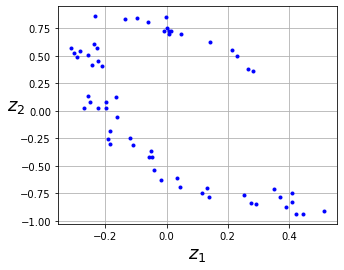

In [ ]:
fig = plt.figure(figsize=(5,4))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# Stacked Autoencoders
<mark>Autoencoders having multiple hidden layers are capable of learning more complex codings, such autoencoders are called ***stacked*** or ***deep autoencoders***.</mark>

Also make sure you DO NOT make the autoencoder to powerful.

The architecture of a stacked autoencoder is typically kept symmetrical.


## Implementing a Stacked Autoencoder Using keras
Let's build a stacked autoencoder for the fashion MNIST dataset.

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
stacked_decoder = keras.models.Sequential([
     keras.layers.Dense(100, activation="selu", input_shape=[30]),
     keras.layers.Dense(28*28, activation="sigmoid"),
     keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                81530     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stacked_ae.compile(loss="binary_crossentropy",   # treating the reconstruction task as a
                                                 # multilabel binary classification problem
                   optimizer=keras.optimizers.SGD(learning_rate=1.5),
                   metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train,
                         epochs=20,
                         validation_data=(tf.convert_to_tensor(X_valid), 
                                          tf.convert_to_tensor(X_valid)))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3172 - val_rounded_accuracy: 0.8990
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9151 - val_loss: 0.3020 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2983 - val_rounded_accuracy: 0.9204
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

## Visualizing the Reconstruction

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

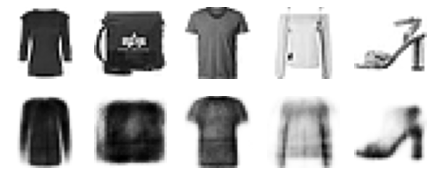

In [ ]:
show_reconstructions(stacked_ae)

## Visualizing Fashion MNIST Dataset
The results are not great but autoencoders handle large datasets. That's why <mark>we ususally use an autoencoder to reduce the dimensionality down to a reasonable level then use another dimensionality reduction techniques for visualzation.</mark>

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

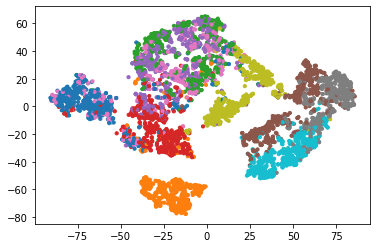

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")

In [ ]:
X_valid_2D

array([[ -4.5233026,  43.172134 ],
       [ 22.173399 ,  33.79088  ],
       [-73.944435 ,  11.509445 ],
       ...,
       [-35.011307 ,  -6.563963 ],
       [-56.531036 ,   6.7015786],
       [ 56.21696  ,  15.960167 ]], dtype=float32)

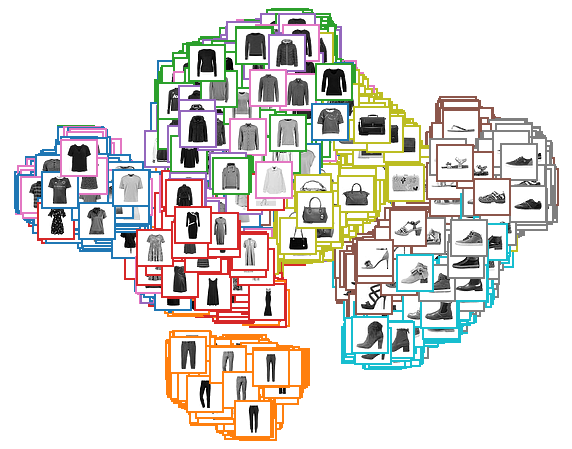

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Unsupervised Pretraining Using Stacked Autoencoders
If we have a large dataset but most of it is unlabeled, we can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for our actual task and train it using the labeled data.

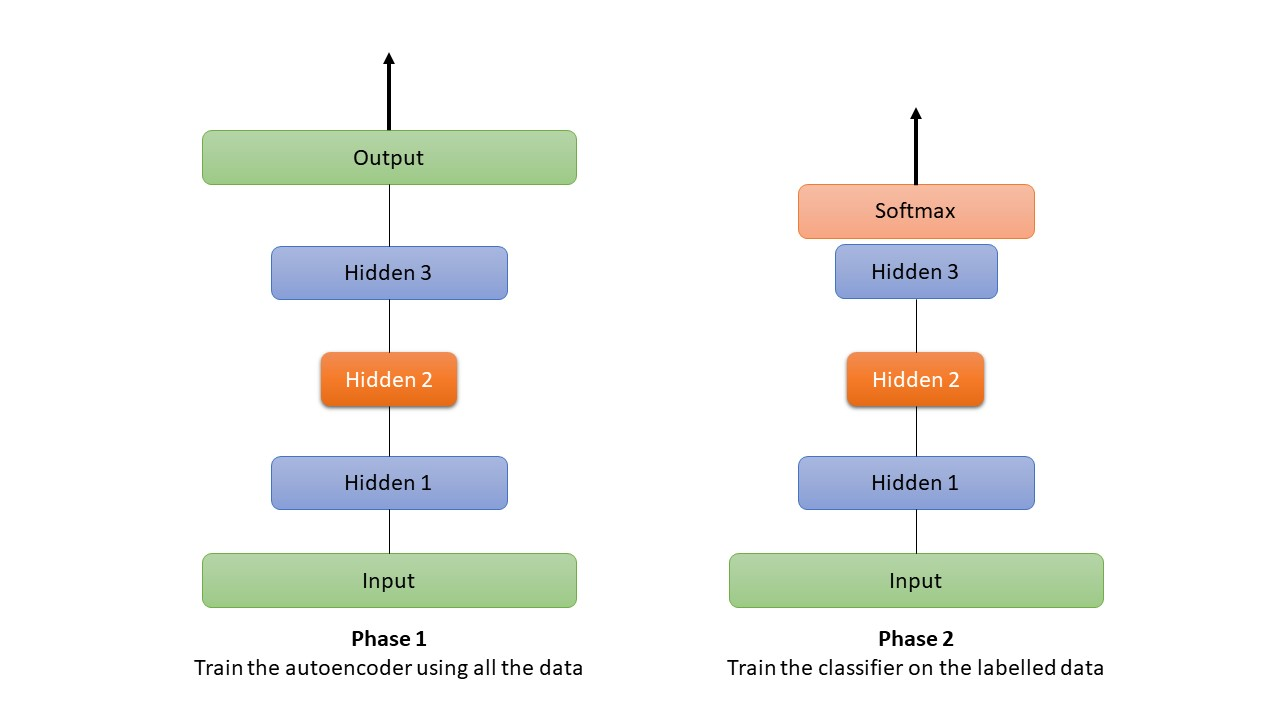

Let's look at few techniques to train stacked autoencoders.

## Tying Weights
It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [ ]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias",
                                  initializer="zeros",
                                  shape=[self.dense.input_shape[-1]]) # bias vector length comes from 
    super().build(batch_input_shape)                                  # the number of units in pervious layer
                                                                      # or previous layer outputs last dimension
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)    # perform normal X.W but with W from dense
    return self.activation(z + self.biases)

In [ ]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_21 (Sequential)   (None, 28, 28)            82414     
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), 
                metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9342 - val_loss: 0.2869 - val_rounded_accuracy: 0.9345
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2839 - rounded_accuracy: 0.9351 - val_loss: 0.2844 - val_rounded_accuracy: 0.9355
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2830 - rounded_accuracy: 0.9360 - val_loss: 0.2913 - val_rounded_accuracy: 0.9208
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2824 - rounded_accuracy: 0.9365 - val_loss: 0.2835 - val_rounded_accuracy: 0.9375
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2818 - rounded_accuracy: 0.9370 - val_loss: 0.2824 - val_rounded_accuracy: 0.9382
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2814 - rounded_accuracy: 0.9374 - val_loss: 0.2832 - val_rounded_accuracy: 0.9365
Epoch 7/10
1719/1719 [==================

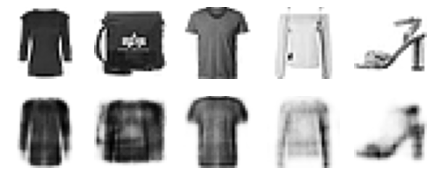

In [ ]:
show_reconstructions(tied_ae)

## Convolutional Autoencoders
Convolution layers are better at dealing images than simple NN. To perform unsupervised pretraining or dimensionality reduction on images we beed a *Convolution autoencoder*.

<mark>This encoder is a reguar CNN composed of convolutional layers and pooling layer. It typically reduces the spatial dimensionality of the inputs (i.e., height and weight) while increasing the depth (i.e., the number of feature maps). The decoder must do the same except in reverse.</mark>

In [ ]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                 activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_encoder.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)        

In [ ]:
conv_decoder.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_5 (Conv2DTr (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_11 (Reshape)         (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_ae.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_27 (Sequential)   (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_28 (Sequential)   (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_ae.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 64s 37ms/step - loss: 0.2916 - rounded_accuracy: 0.9271 - val_loss: 0.2821 - val_rounded_accuracy: 0.9382
Epoch 2/5
1719/1719 [==============================] - 64s 37ms/step - loss: 0.2750 - rounded_accuracy: 0.9420 - val_loss: 0.2723 - val_rounded_accuracy: 0.9460
Epoch 3/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.2704 - rounded_accuracy: 0.9466 - val_loss: 0.2704 - val_rounded_accuracy: 0.9483
Epoch 4/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.2680 - rounded_accuracy: 0.9492 - val_loss: 0.2673 - val_rounded_accuracy: 0.9515
Epoch 5/5
1719/1719 [==============================] - 65s 38ms/step - loss: 0.2662 - rounded_accuracy: 0.9512 - val_loss: 0.2663 - val_rounded_accuracy: 0.9525


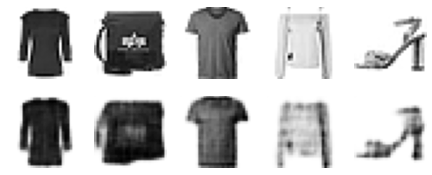

In [ ]:
show_reconstructions(conv_ae)

# Recurrent Autoencoders
To build an autoencoder for sequences, we need a *recurrent autoencoder*:<mark> the encoder is typically a sequence-to-vector RNN and the decoder is a vector-to-sequence RNN that does the reverse.

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),  # ensure that its input gets fed to the 
    keras.layers.LSTM(100, return_sequences=True),    # the decoder at each time step
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [ ]:
recurrent_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         51600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 28, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 100)           52400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 28)            2828      
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 30)                67320     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_ae.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, 
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 22s 9ms/step - loss: 0.5108 - rounded_accuracy: 0.7590 - val_loss: 0.4447 - val_rounded_accuracy: 0.8215
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4078 - rounded_accuracy: 0.8410 - val_loss: 0.3817 - val_rounded_accuracy: 0.8615
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3693 - rounded_accuracy: 0.8677 - val_loss: 0.3627 - val_rounded_accuracy: 0.8728
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3540 - rounded_accuracy: 0.8773 - val_loss: 0.3508 - val_rounded_accuracy: 0.8814
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3426 - rounded_accuracy: 0.8854 - val_loss: 0.3386 - val_rounded_accuracy: 0.8878
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3346 - rounded_accuracy: 0.8908 - val_loss: 0.3359 - val_rounded_accuracy: 0.8938
Epoch 7/10
1719/1719 [============

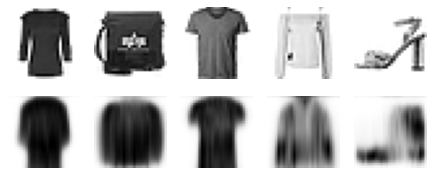

In [ ]:
show_reconstructions(recurrent_ae)

There are actually many other kinds of constraints that can be used (other than limiting the size of coding layer),<mark> one even allowing the coding layer to be just as large as the inputs, or even larger, creating an ***overcomplete autoencoder***.</mark>

# Denoising Autoencoders
<mark>Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original inputs.</mark>

The noise could be pure gaussian noise (using `GaussianNoise` layer) or randomly switched-off inputs, just like in dropout (using `Dropout` layer). 

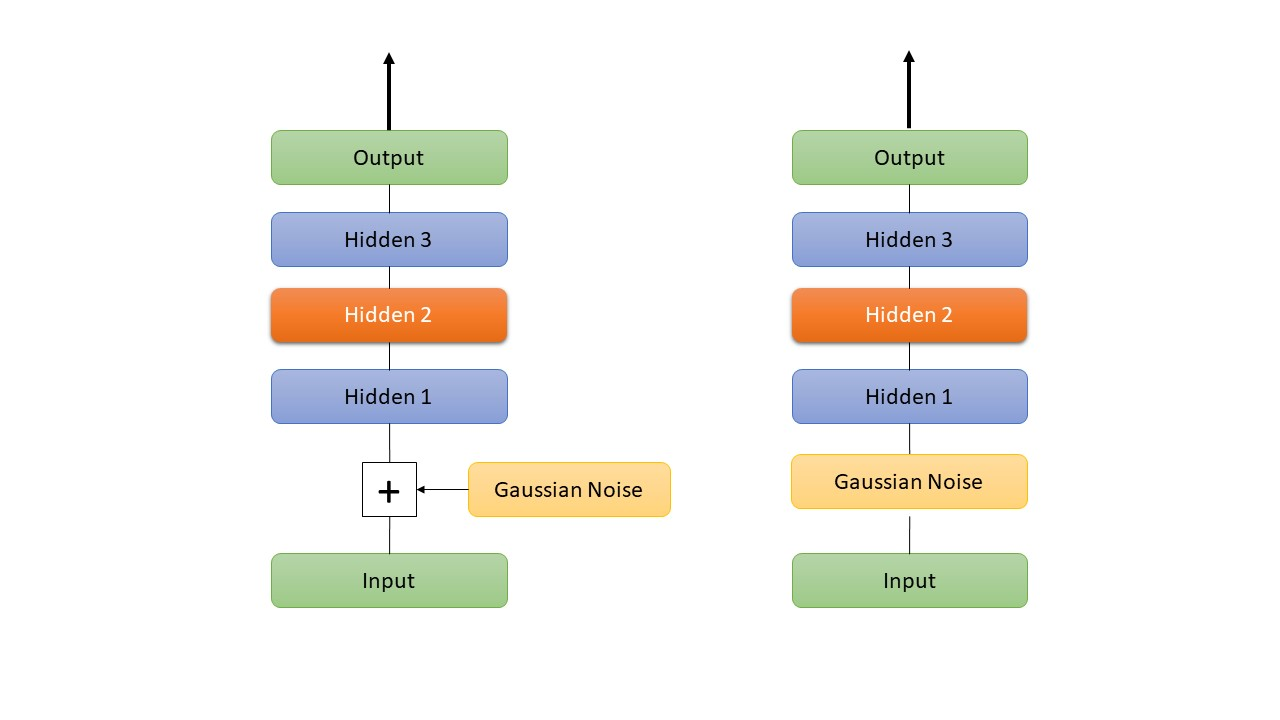

In [ ]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [ ]:
dropout_ae.compile(loss="binary_crossentropy", 
                   optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3635 - rounded_accuracy: 0.8657 - val_loss: 0.3226 - val_rounded_accuracy: 0.9020
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3203 - rounded_accuracy: 0.9015 - val_loss: 0.3132 - val_rounded_accuracy: 0.9095
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3136 - rounded_accuracy: 0.9068 - val_loss: 0.3082 - val_rounded_accuracy: 0.9138
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3099 - rounded_accuracy: 0.9098 - val_loss: 0.3057 - val_rounded_accuracy: 0.9170
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3074 - rounded_accuracy: 0.9119 - val_loss: 0.3030 - val_rounded_accuracy: 0.9185
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9134 - val_loss: 0.3022 - val_rounded_accuracy: 0.9169
Epoch 7/10
1719/1719 [==================

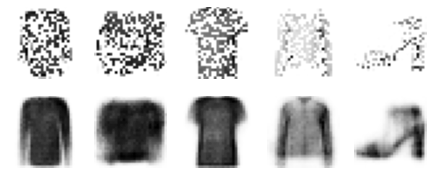

In [ ]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

# Sparse Encoders
Another kind of constraint we can use to train autoencoder is *sparsity*:<mark> by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer.</mark>

1. **simple approach**: 
  - use the sigmoid activation function in the coding layer,
  - use a larger coding layer and 
  - add some $\ell_1$ regularization to the coding layer's activations. 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_enoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),  # use the sigmoid activation 
                                                    # to ensure that the coding values range from 0 to 1
    keras.layers.ActivityRegularization(l1=1e-3)
  # keras.layers.Dense(300, activation="sigmoid",                        # same as above 2 lines | replace it with 
  #                    activity_regularizer=keras.regularizers.l1(1e-2)) # Dense and AcitvityRegularization layer
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_enoder, sparse_l1_decoder])

In [ ]:
sparse_l1_ae.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(learning_rate=1.),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

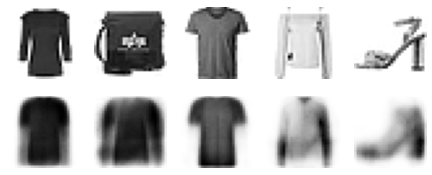

In [ ]:
show_reconstructions(sparse_l1_ae)

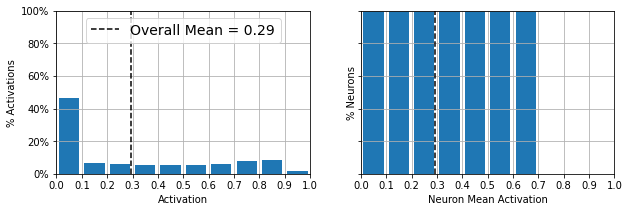

In [ ]:
plot_activations_histogram(sparse_l1_ae, height=1.)

2. **Another approach**: <mark>Measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparsity differs from the target sparsity.</mark>

  To do this we need to compute the average activation of each neuron in the coding layer, over the whole training batch.

  Once we have the mean activations per neuron (actual sparsity $q$), we want to penalize the neurons that are too active, or not active enough, <mark>by adding a *sparsity loss* to the cost function.</mark>

  To do this we use Kullback-Leibler (KL) divergence.

> Given two discrete probability distributions $P$ and $Q$, the KL divergence between  these distributions can be computed using:
>  
>  $$D_{(KL)}(p\parallel q)=\sum_i P(i) \log \frac{P(i)}{Q(i)}$$

> <mark>To measure the divergence between the target probability $p$ (which we define) that a neuron in the coding layer will activate and the actual probability $q$ (i.e., the mean activation over the training batch:</mark>
>
> $$D_{(KL)}(p\parallel q) = p\log \frac{p}{q} + (1-p) \log\frac{1-p}{1-q}$$



(0.0, 1.0, 0.0, 0.95)

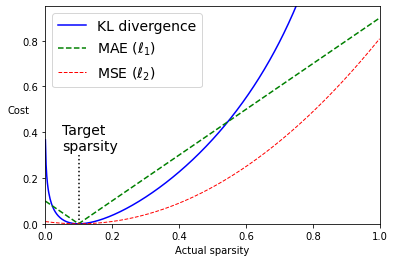

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1 - self.target, 1 - mean_activities)
    )

In [ ]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1) # target/ target probability (p)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid",
                       activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

In [ ]:
sparse_kl_ae.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(1.0),
                     metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4129 - rounded_accuracy: 0.8147 - val_loss: 0.3683 - val_rounded_accuracy: 0.8634
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3504 - rounded_accuracy: 0.8795 - val_loss: 0.3418 - val_rounded_accuracy: 0.8872
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3318 - rounded_accuracy: 0.8941 - val_loss: 0.3273 - val_rounded_accuracy: 0.8992
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3213 - rounded_accuracy: 0.9029 - val_loss: 0.3207 - val_rounded_accuracy: 0.9051
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3165 - rounded_accuracy: 0.9068 - val_loss: 0.3169 - val_rounded_accuracy: 0.9083
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3130 - rounded_accuracy: 0.9098 - val_loss: 0.3134 - val_rounded_accuracy: 0.9107
Epoch 7/10
1719/1719 [==================

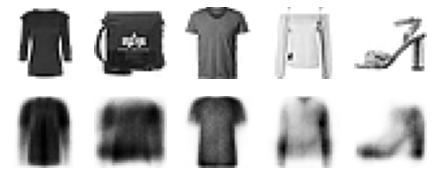

In [ ]:
show_reconstructions(sparse_kl_ae)

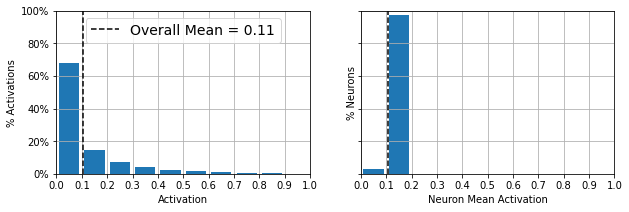

In [ ]:
plot_activations_histogram(sparse_kl_encoder)

# Variational Autoencoders
These are quite different from other decoders we discussed so far in the sense that:
- <mark>They are *probabilistic autoencoders*, thier outputs are partly determined by chance, even after training.</mark>
- <mark>They are *generative autoencoders*, meaning that they can generate  new instances that look like they were sampled from the training set.</mark>

To do this the encoder produces a *mean coding* $\mu$ and a standard deviation $\sigma$. The actual coding is then sampled from a Gaussian distribution with the mean  $\mu$ and standard deviation  $\sigma$.

Talking about the cost function, is made  up of two parts:
- The first the usual reconstruction  loss that pushes the autoencoder to reproduce its inputs.
- The second is the *latent loss* that pushes the autoencoder to have codings that look as though they were sampled from a single Gaussian distribution (although the codings are not limited to Gaussian distribution only): <mark>it is the KL divergence between the target distribution and the actual distribution of the codings</mark>

*Equation 17-3. Variational autoencoders' latent loss*
$$\mathscr{L} = -\frac{1}{2}\sum_{i=1}^K 1+ \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2$$

In this equation :
- $\mathscr{L}$ is the laten loss
- $n$ is the codings dimensionality
- $\mu_i$ and $\sigma_i$ (both part of $\mu$ and $\sigma$ which was outputted by the encoder) are the mean and the standard deviation of the i<sup>th<sup> component of the codings.

>*Equation 17-4. Variational autoencoders' latent loss, rewritten using $\gamma=\log(\sigma^2)$*
$$\mathscr{L} = -\frac{1}{2} \sum_{i=1}^{K}1+\gamma_i -\exp(\gamma_i) - \mu_i^2$$

Let's start building a variational autoencoder for MNIST dataset.

First, we'll build a custom layer to sample the codings, given `mean` ($\mu$) and `log_var` ($\gamma$):

In [ ]:
K = keras.backend

class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return (K.random_normal(tf.shape(log_var))   # 1. sample a random vector of same shape as log_var or (γ)
                                                 #    with mean 0 and standard deviation 1.
            * K.exp(log_var / 2)                 # 2. multiply by σ
            + mean)                              # 3. add the μ

> **Note**: Multiplication of `k.exp(log_var / 2)` or $\exp(\gamma / 2 )$ is equal to $\sigma$.
> 
> **Explanation**:
> - $\gamma = \log(\sigma^2)$
> - $\gamma = 2\log(\sigma)$
> - $\frac{\gamma}{2} = \log{\sigma}$
> - $e^{\gamma/2} = \sigma$

Next, create the model with Functional API.

In [ ]:
codings_size = 10

encoder_inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(encoder_inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)     # μ
codings_log_var = keras.layers.Dense(codings_size)(z)  # σ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=[encoder_inputs], outputs=[codings_mean, codings_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="selu")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

Now we can build our complete variational autoencoder like this:

In [ ]:
_, _, codings = variational_encoder(encoder_inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

Lastly, we must add the latent loss and the reconstruction loss:

In [ ]:
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.mean(codings_mean), 
                           axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784. )  # mean loss over all the intances
                                                      # dividing to ensure it has the appropriate scale 
                                                      # compared to the reconstruction loss
variational_ae.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, 
                             epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 8s 15ms/step - loss: 0.5479 - rounded_accuracy: 0.8295 - val_loss: 0.3655 - val_rounded_accuracy: 0.8759
Epoch 2/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3897 - rounded_accuracy: 0.8688 - val_loss: 0.3522 - val_rounded_accuracy: 0.8861
Epoch 3/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3688 - rounded_accuracy: 0.8762 - val_loss: 0.3404 - val_rounded_accuracy: 0.8895
Epoch 4/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3501 - rounded_accuracy: 0.8835 - val_loss: 0.3326 - val_rounded_accuracy: 0.8931
Epoch 5/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3437 - rounded_accuracy: 0.8831 - val_loss: 0.3081 - val_rounded_accuracy: 0.9006
Epoch 6/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3264 - rounded_accuracy: 0.8745 - val_loss: 0.6535 - val_rounded_accuracy: 0.8198
Epoch 7/25
430/430 [==========================

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


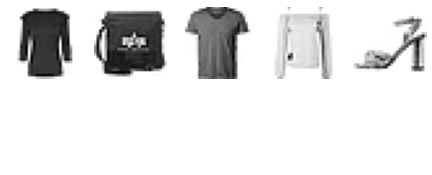

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

show_reconstructions(variational_ae)

## Generating Fashion MNIST Images
To genearte images of fashion items, we just need to sample  random codings from a gaussian distribution and decode them:

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


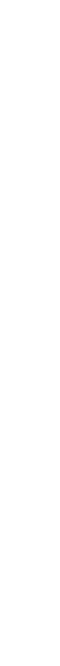

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 1)

Varitational encoders can also allow us to perform *semantic interpolation*: instead of interpolating two images at the pixel level, we can interpolate at the codings level.



/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


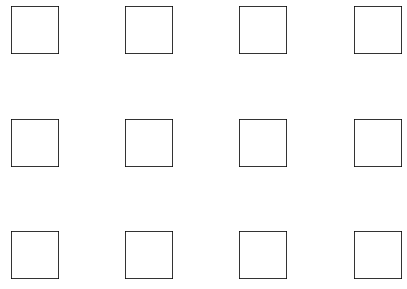

In [ ]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_gird = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_gird, [-1, codings_size])
images = variational_decoder(interpolated_codings)

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

# Generative Adversarial Networks
As discribed earlier, composed of two parts:
- **Genrator**: Takes a random distribution as inputs ( as latent representations of the image to be generated) and output some data, another image.

  The purpose of the generator is to trick the discriminator that the images it produced are fake.
- **Discriminator**: Takes either a fake image from the generator or a real image from the trainging set as input, and must guess whether the input image is fake or real.

  The discriminators job is to tell fake images from real images.

## Training procedure of GANs
Each training iteration consists of two phases:
- **First phase:** *Train the discriminator* | backpropagation updates the weights of the discriminator.

  A batch of real images from the training set (labeled 0) and equal amount of fake images produced by the generator (labeled 1) is created. Discriminator is trained on this batach for one step.

- **Second phase:** *Train the generator* | backpropagation only affects the weights of generator

  Since we want the generator to produce images that the discriminator will (wrongly) believe to be real, A batch of only fake images are generated (labeled 1) (NO REAL IMAGES) and the discriminator is used to tell whether the image is fake or not.

Let's go and build a simple GAN for Fashion MNIST.


In [ ]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy",
                      optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",
            optimizer='rmsprop')

Then we write a cutom training loop. But first we need to create a `Dataset` to iterate through the images.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1_000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


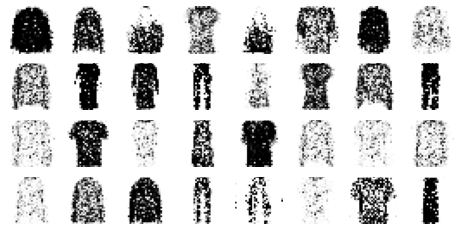

Epoch 2/10


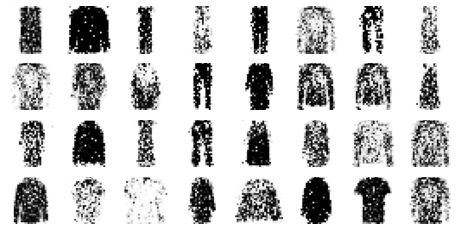

Epoch 3/10


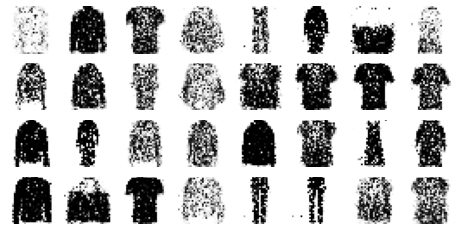

Epoch 4/10


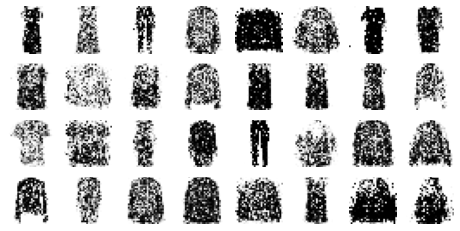

Epoch 5/10


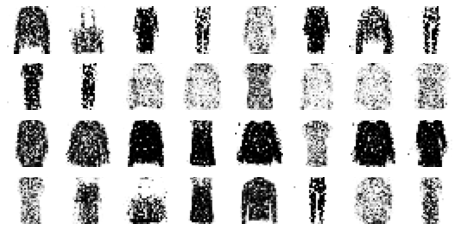

Epoch 6/10


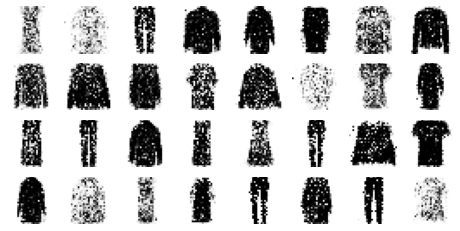

Epoch 7/10


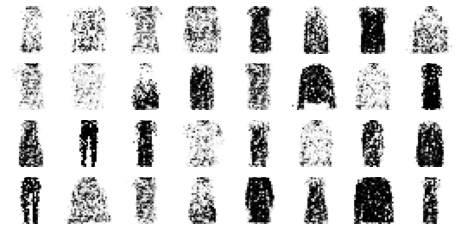

Epoch 8/10


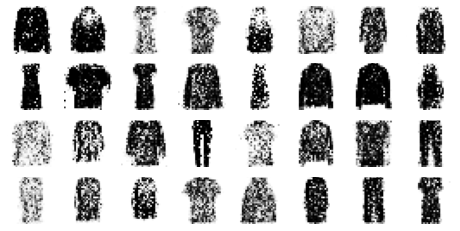

Epoch 9/10


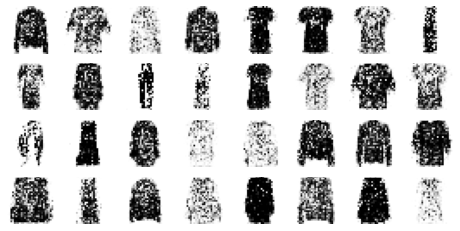

Epoch 10/10


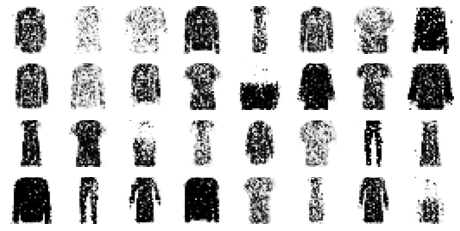

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs): 
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for X_batch in dataset:
      # Phase 1: training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)

      # Phase 2: training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_multiple_images(generated_images, 8) 
    plt.show()      
    
train_gan(gan, dataset, batch_size, codings_size)

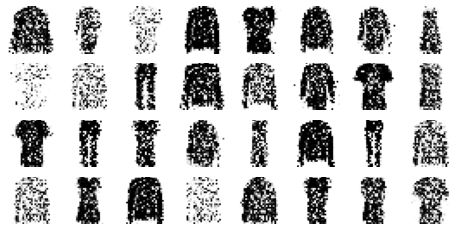

In [ ]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

## Deep Convolutional GANs
In late 2015, Alec Radford et al. were successfull in creating deep convolutional nets for larger images with stable training. These were the main guidlines:

- <mark>Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).</mark>
- <mark>Use Batch Normalization in both the generator and the discriminator, except in the generator's output layer and the discriminator's input layer.</mark>
- <mark>Remove fully connected hidden layers for deeper architectures.</mark>
- <mark>Use ReLU activation in the generator for all layers except the output layer, which should use tanh.</mark>
- <mark>Use Leaky ReLU activation in the discriminator for all layers.</mark>


In [ ]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, 
                                 padding="same", 
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                 padding="same", 
                                 activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, 
                        padding="same", 
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, 
                        padding="same",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
dcgan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
# rescale since output layer of generator uses tanh activation function
# reshape to add the channel dimension
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


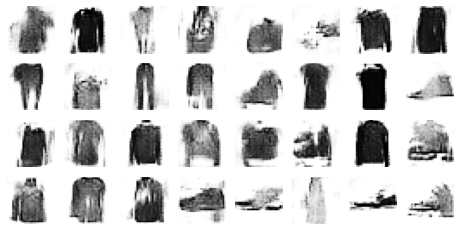

Epoch 2/10


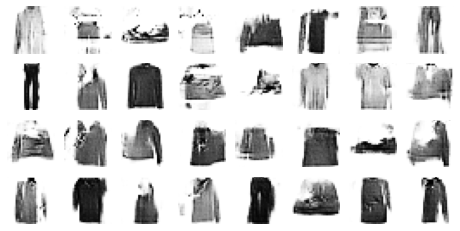

Epoch 3/10


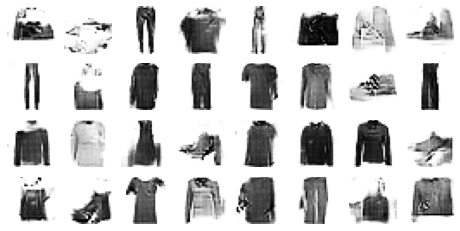

Epoch 4/10


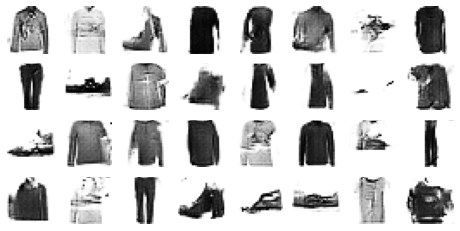

Epoch 5/10


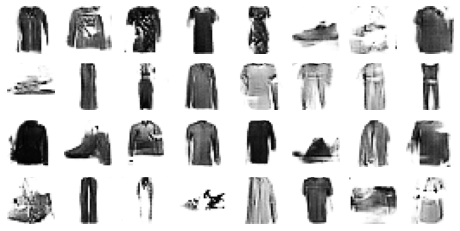

Epoch 6/10


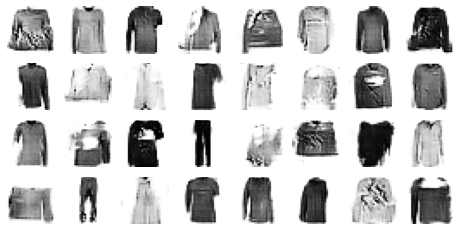

Epoch 7/10


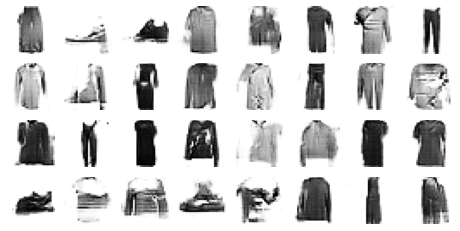

Epoch 8/10


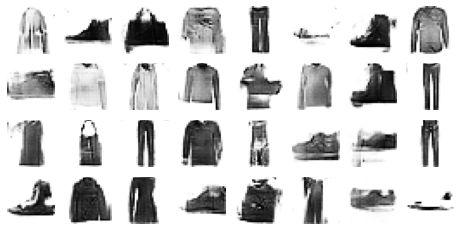

Epoch 9/10


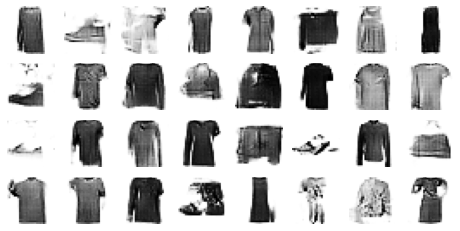

Epoch 10/10


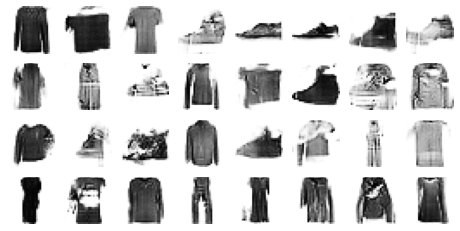

In [ ]:
train_gan(dcgan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

## Progressive growing of GANs
Several techniques introduced to increase the diversity of the outputs and making training more stable.

***Minibatch standard deviation layer***
- <mark>Added near the end of the discriminator.</mark>
- Avoid the discriminator to be fooled easily as we add statiscs information to each instance in the batch.
- Steps:
1. Computes the standard  deviation across all the channels and all instances in the batch.

  `S = tf.math.reduce_std(inputs, axis=[0, -1]))`
2. Average them across all the points to get a single value.

  `v = tf.reduce_mean(S)`
3. Add an extra feature map to each instances in the batch filled with the computed value.

  `tf.concat([inputs, tf.fill([batch_size, height, width, 1], v)], axis=-1)`

***Equalized learning rate***
- <mark>Initializes all weights using a simple Gaussian distribution with mean 0 and standard deviation of 1 rather than using He initialization.</mark>
- However, the <mark>weights are scaled down</mark> at runtime by the same factor as in He initialization: they are <mark>divided  by $\sqrt{2/n_{\text{inputs}}}$ </mark>where $n_\text{inputs}$ is the number of inputs to the layer.

***Pixelwise normalization layer***
- Added after the convolutional layer in the generator.
- <mark>Normalizes each activation based on all the activations in the same image and at the same location, but across all channels.</mark>

  `inputs / tf.sqrt(tf.reduce_mean(tf.square(X), axis=-1, keepdims=True) + 1e-8`


## StyleGANs

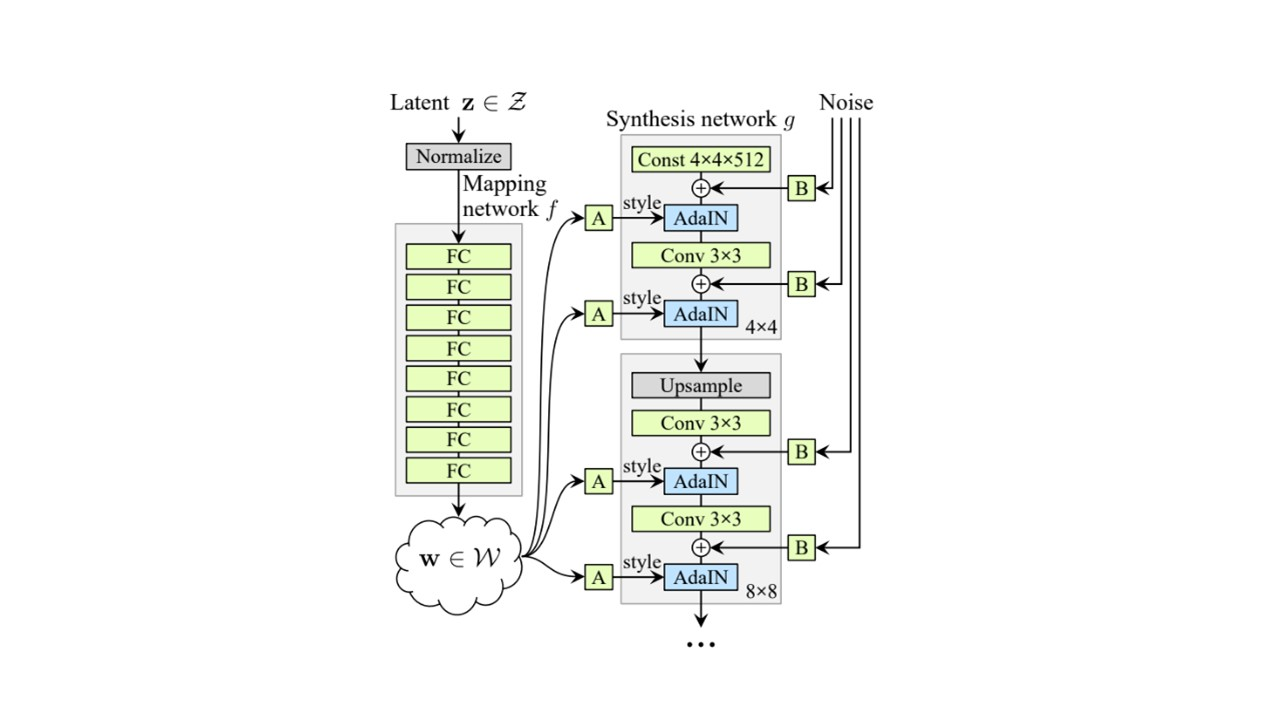


Image from [Paper with code](https://paperswithcode.com/method/stylegan#)

Composed of two networks:

- ***Mapping network***

  <mark>Maps the codings to multiple style vectors.</mark>

  An eight layer MLP (left side of above figure) maps the latent representations or codings $z$ to a vector $w$. This vector is then sent through <mark>***affine transformations*** to produce mutiple style vectors</mark> containing <mark>one scale and one bias term for each feature map. </mark>
  
  These style vectors controls the style of the generated image at different levels.

- ***Synthesis network***

  <mark>Responsible for generating the images.</mark>

  Few important things:
  - It <mark>adds some noise to the input and to all the outputs of the convolutional layers.</mark>
  - Each noise is followed by ***Adaptive Normalization*** (AdaIN) layer:
    - <mark>standardizes each feature map</mark> independently, then uses the <mark>style vectors to determine the scale and offset of each feature map.</mark>

